**Libraries**

In [27]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.oauth2 as oauth2
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns 
%config InlineBackend.figure_format ='retina'
import random
from functools import reduce
from sklearn.ensemble import RandomForestRegressor
from datetime import date
import time
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

**Spotify API Call**

In [28]:
#used for inserting your username and credentials that you can obtain from spotify developer
client_id= 'ebbb035aedf7428cbdbbd6dd31df89a8'
client_secret= '394032044ced4d8e9df0f9d435f88794'

redirect_uri='http://localhost:8910/callback'
username='224qqnsvbhlau4fhtpl4wpogi'

scope ='user-top-read'


In [29]:
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, 
                                                      client_secret=client_secret)
                                                      
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

token = util.prompt_for_user_token(username,scope, client_id, client_secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

**Extract Top Tracks**

In [30]:
results = sp.current_user_top_tracks(limit=50, offset=0,time_range='long_term')

# Convert the results into a dataframe

track_name=[]
track_id=[]
artist=[]
new=[]
album=[]
duration=[]
popularity=[]

for i, items in enumerate(results['items']):
        track_name.append(items['name'])
        track_id.append(items['id'])
        artist.append(items["artists"][0]["name"])
        duration.append(items["duration_ms"])
        album.append(items["album"]["name"])
        popularity.append(items["popularity"])

# Create the final df   
df_top_tracks = pd.DataFrame({ "track_name": track_name, 
                             "album": album, 
                             "track_id": track_id,
                             "artist": artist, 
                             "duration": duration, 
                             "popularity": popularity})

df_top_tracks

,track_name,album,track_id,artist,duration,popularity
0,MIDDLE CHILD,MIDDLE CHILD,2JvzF1RMd7lE3KmFlsyZD8,J. Cole,213593,80
1,Climax (feat. 6lack),On the Run,4N9QsmvQJcGwJHAmDmBttU,Young Thug,189093,60
2,سماع منّي وضل سكار,سماع منّي وضل سكار,4C6gnywwpZWQa8ixhwrSKU,Bassel Sakr,141191,8
3,Stan,East Atlanta Love Letter,1mggAh6xgnKUT6ukw3AU9A,6LACK,303750,55
4,You Are The Reason - Duet Version,Only Human (Special Edition),1x3W8RZxW94lrVGhP95qA6,Calum Scott,190760,69
5,Sin (feat. Jaden Smith),On the Run,1Jl21sidRpEdlVBvYbssLx,Young Thug,202533,61
6,Into You,10X over Riddim (Soca 2019 Trinidad and Tobago...,7pwmtknVJmDfTBSvtzhBEU,Precision Productions,198167,0
7,Whole Wide World,Whole Wide World,6lKKCEeRunxMGM8xgejlyd,Berhana,243160,38
8,Broke,Broke,1JqcZQCnxjDOfZZwQidb1H,Samm Henshaw,207722,61
9,The Box,Please Excuse Me For Being Antisocial,0nbXyq5TXYPCO7pr3N8S4I,Roddy Ricch,196652,87


**Feature Extraction**

In [31]:
def get_features(sp,df):
    playlist = df[['track_id','track_name']]
    features = []
    
    features += sp.audio_features(playlist.iloc[0:50, 0])

    feature_list = []
    for feature in features:
        feature_list.append([feature['danceability'],
                        feature['energy'],
                        feature['key'],
                        feature['loudness'],
                        feature['mode'],
                        feature['speechiness'],
                        feature['acousticness'],
                        feature['instrumentalness'],
                        feature['liveness'],
                        feature['valence'],
                        feature['tempo'],
                        feature['duration_ms']]
                       )

    df_audio_feature = pd.DataFrame(feature_list, columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
                                                          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                                                          'duration_ms'])
    df_playlist_audio_features = pd.concat([playlist, df_audio_feature], axis=1)
    return df_playlist_audio_features

In [32]:
df_final_features = get_features(sp,df_top_tracks)
#Drop the mode feature as it is binary
del df_final_features['mode']
df_final_features

,track_id,track_name,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,2JvzF1RMd7lE3KmFlsyZD8,MIDDLE CHILD,0.837,0.364,8,-11.713,0.2760,0.149000,0.000000,0.2710,0.4630,123.984,213594
1,4N9QsmvQJcGwJHAmDmBttU,Climax (feat. 6lack),0.829,0.362,0,-11.546,0.2310,0.060800,0.000000,0.1350,0.3690,122.912,189093
2,4C6gnywwpZWQa8ixhwrSKU,سماع منّي وضل سكار,0.743,0.759,1,-4.841,0.1640,0.131000,0.000000,0.3900,0.8000,99.979,141192
3,1mggAh6xgnKUT6ukw3AU9A,Stan,0.333,0.328,3,-9.144,0.0401,0.821000,0.000173,0.1270,0.1520,92.889,303750
4,1x3W8RZxW94lrVGhP95qA6,You Are The Reason - Duet Version,0.403,0.356,10,-7.547,0.0298,0.382000,0.000000,0.1480,0.1510,171.454,190760
5,1Jl21sidRpEdlVBvYbssLx,Sin (feat. Jaden Smith),0.889,0.385,11,-11.767,0.1650,0.005440,0.000000,0.2740,0.2350,125.995,202533
6,7pwmtknVJmDfTBSvtzhBEU,Into You,0.883,0.841,1,-2.802,0.1580,0.176000,0.000000,0.1250,0.6550,99.978,198168
7,6lKKCEeRunxMGM8xgejlyd,Whole Wide World,0.508,0.457,4,-7.320,0.0383,0.849000,0.000000,0.0989,0.4870,100.221,243160
8,1JqcZQCnxjDOfZZwQidb1H,Broke,0.751,0.684,1,-4.325,0.3030,0.433000,0.000006,0.1800,0.8640,89.984,207722
9,0nbXyq5TXYPCO7pr3N8S4I,The Box,0.896,0.586,10,-6.687,0.0559,0.104000,0.000000,0.7900,0.6420,116.971,196653


We can take a look at the frequency of the values present in each feature.

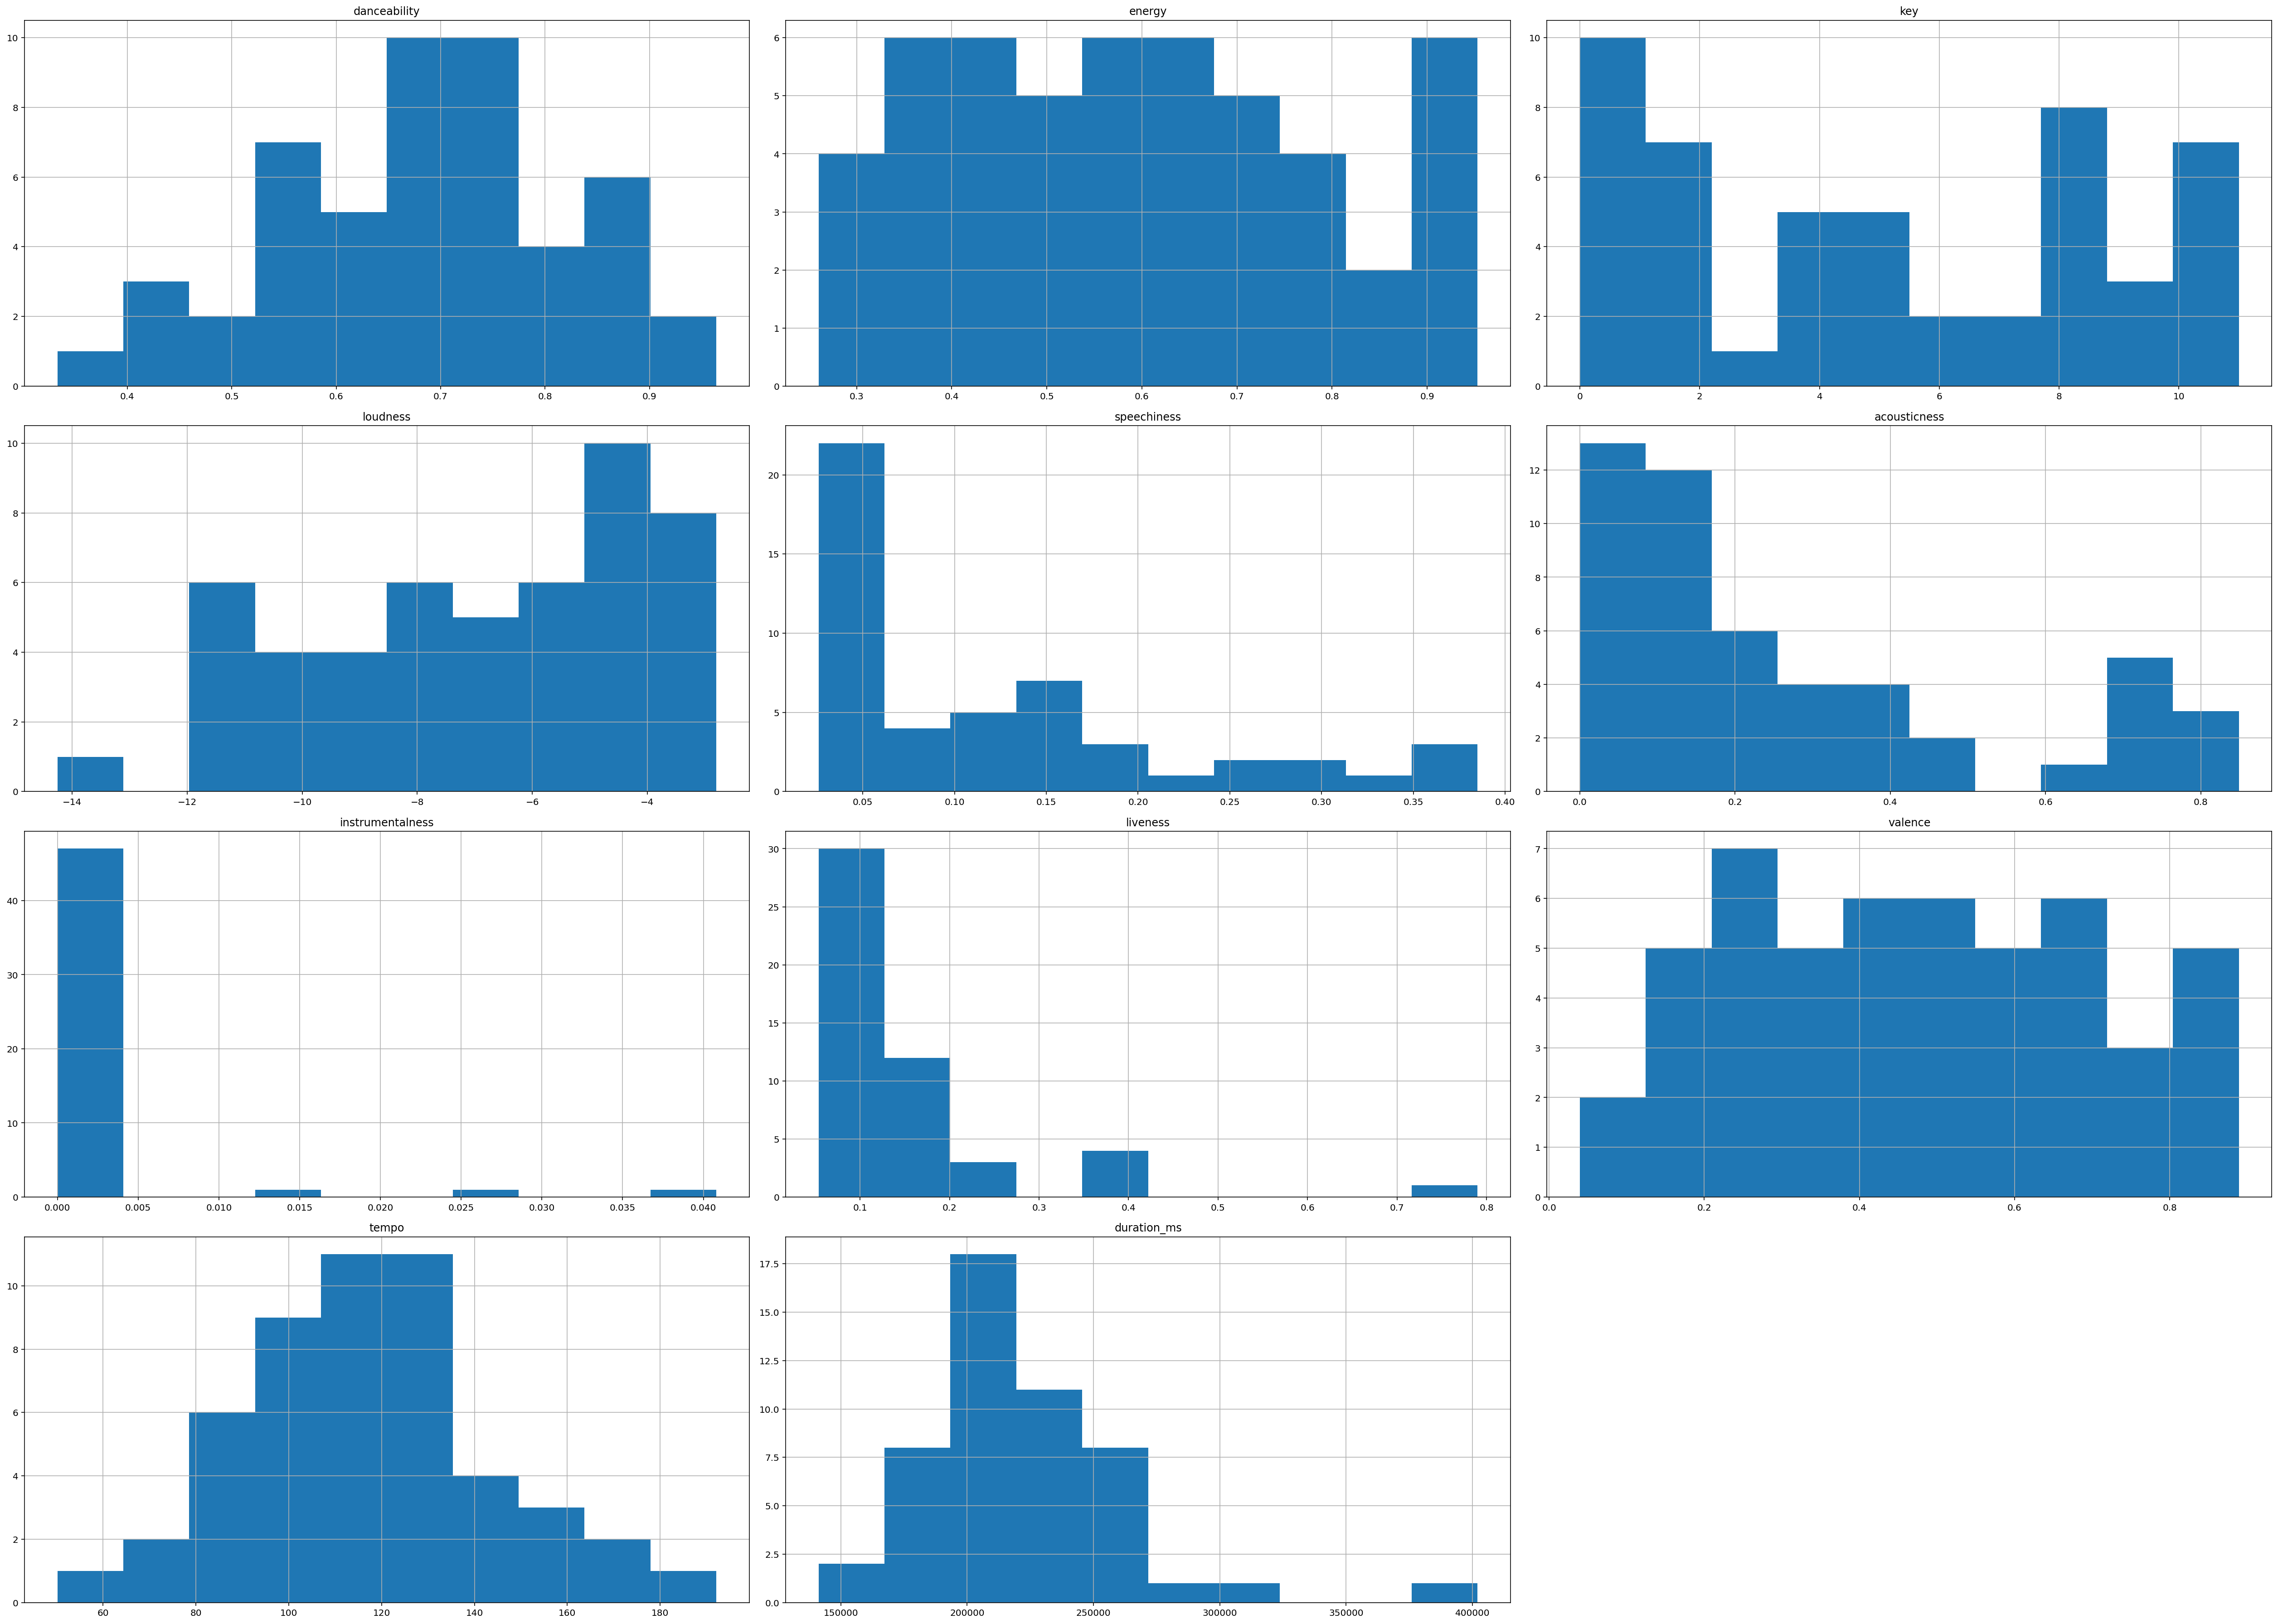

In [33]:
df_final_features.hist(figsize=(35,25)) 
plt.tight_layout()
plt.show()

I will now take all my built up playlist to then create one complilation of the best songs using the features provided. 

** User PLaylist Extraction **

In [34]:
def user_playlist(sp,username):
    playlist_id = []
    playlist_name = []
    num_tracks = []
    
    featured = sp.user_playlists(username)
    for i, items in enumerate(featured['items']):
        playlist_id.append(items['id'])
        playlist_name.append(items['name'])
        num_tracks.append(items['tracks']['total'])
    
    df_your_lib = pd.DataFrame({'playlist_id':playlist_id, 'playlist_name':playlist_name, '#tracks': num_tracks})
    return df_your_lib

In [35]:
df_user_playlists = user_playlist(sp,username)
searchfor = ['Custom', 'Discover']
df_user_playlists =  df_user_playlists[~df_user_playlists['playlist_name'].str.contains('|'.join(searchfor))]
df_user_playlists

,playlist_id,playlist_name,#tracks
0,1S455AG3UORA5W0HPZZmlI,Yara,53
1,2b3WqN1B0sLJLk7QjktR8W,My Shazam Tracks,2


I dont have many custom playlists, so i will manually add playlists that I enjoy as well as remove any playlist that doesnt have more than 10 songs to ensure we have sufficient data. 

In [36]:
#df_user_playlists= df_user_playlists.drop(df_user_playlists.index[1])

listOfSeries = [pd.Series(['1QnKkNOpY8jPDIUT4oulDH', 'Nida recomendations', 60], index=df_user_playlists.columns ) ,
                pd.Series(['2XH7v4B8Tf9D4UYJPxtJlX', 'throwback', 279], index=df_user_playlists.columns ) ,
                pd.Series(['4JbURQJ0cA9Go65G0JmBq8', 'train', 20], index=df_user_playlists.columns ) ]


df_user_playlists= df_user_playlists.append(listOfSeries , ignore_index=True)

df_user_playlists.drop( df_user_playlists[ df_user_playlists['#tracks']<10 ].index , inplace=True)
df_user_playlists

,playlist_id,playlist_name,#tracks
0,1S455AG3UORA5W0HPZZmlI,Yara,53
2,1QnKkNOpY8jPDIUT4oulDH,Nida recomendations,60
3,2XH7v4B8Tf9D4UYJPxtJlX,throwback,279
4,4JbURQJ0cA9Go65G0JmBq8,train,20


Now that my list of playlists has been made, we can extract the tracks from each playlist to analyze them to single out the best ones. It would be interesting to test this out on an account with many more playlists than I do. But we will go on with what we have.

**Fetching tracks for each playlist**

In [37]:
def get_playlist_tracks(sp, playlist_id):
    tracks = []
    offset = 0
    while True:
        track_list = sp.playlist_tracks(playlist_id, fields = None, limit = 100, offset = offset, market = None)
        tracks += track_list['items']
        
        if track_list['next'] is not None:
            offset +=100
        else:
            break
            
    track_id = []
    track_name = []
    
    try:
        for track in tracks:
            track_id.append(track['track']['id'])
            track_name.append(track['track']['name'])
    except:
            pass
    
    df_playlist_tracks = pd.DataFrame({'track_id':track_id, 'track_name': track_name})
    return df_playlist_tracks

In [38]:
#test the function
get_playlist_tracks(sp, '1S455AG3UORA5W0HPZZmlI')

,track_id,track_name
0,1bxP4M9ICllcg7mel8kH89,Reine
1,1hnk0ZhStnRSLRq4u2fM7H,Takke
2,2itnaJvNPHTUeNrY97fNws,Hola Señorita
3,5iqrbO0fhuLMiy9tYGanv6,C'est La Vie
4,2On7uB8PN8JJmBNsms8unQ,Compliqué
5,0CJ31BEjjl1tPIj0CKi9kH,Sapés comme jamais (feat. Niska) - Pilule bleue
6,3a9TMd2Yrza6HXqqlfMtfy,Est-ce que tu m'aimes ? - Pilule bleue
7,5Jzss6xqzVPGTxTUbNqtZY,كزابلنكا
8,1G27BeCfBFQHXbXLJkAps7,Y'a des jours comme ça
9,7bVOm16UuDoDGg3LqnywlH,On va s'aimer


**Analyzing Playlist Features**

In this section we are going to create useful functions for extracting features of tracks and calculating the mean features of playlists.

In [39]:
def get_audio_features(sp, playlist_id):
    playlist = get_playlist_tracks(sp, playlist_id)
    audio_features = []
    
    for i in range(len(playlist)):
        try:
            audio_features.append(sp.audio_features(playlist['track_id'][i]))
        except:
            pass
                         
    feature_list = []
    for feature in audio_features:
        try:
            feature_list.append([feature[0]['danceability'],
                            feature[0]['energy'],
                            feature[0]['key'],
                            feature[0]['loudness'],
                            feature[0]['speechiness'],
                            feature[0]['acousticness'],
                            feature[0]['instrumentalness'],
                            feature[0]['liveness'],
                            feature[0]['valence'],
                            feature[0]['tempo'],
                            feature[0]['duration_ms']]
                               )
        except:
            pass

    df_audio_feature = pd.DataFrame(feature_list, columns = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 
                                                          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                                                          'duration_ms'])
    df_playlist_audio_features = pd.concat([playlist, df_audio_feature], axis=1)
    df_playlist_audio_features = df_playlist_audio_features.dropna()
    return df_playlist_audio_features

In [40]:
def get_audio_features_mean (sp, playlist_id):
    playlist = get_audio_features(sp, playlist_id)
    df_mean_playlist = pd.DataFrame(playlist.mean(),columns = [playlist_id])
    return df_mean_playlist

In [41]:
#we can use the functions created above to look at the features of my favourite playlists
dataframes_user = []
for i in df_user_playlists['playlist_id']:
    dataframes_user.append(get_audio_features_mean(sp, i))
    
dataframes_user

[                  1S455AG3UORA5W0HPZZmlI
 danceability                    0.622321
 energy                          0.729057
 key                             4.490566
 loudness                       -6.344811
 speechiness                     0.076770
 acousticness                    0.329940
 instrumentalness                0.011537
 liveness                        0.188958
 valence                         0.601943
 tempo                         121.197623
 duration_ms                228133.622642,
                   1QnKkNOpY8jPDIUT4oulDH
 danceability                    0.704433
 energy                          0.593417
 key                             5.583333
 loudness                       -6.768667
 speechiness                     0.147068
 acousticness                    0.186673
 instrumentalness                0.008542
 liveness                        0.168542
 valence                         0.422603
 tempo                         121.735717
 duration_ms                21211

In [42]:
#lets make it easier to read by creating a dataframe
df_favourite_playlists = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), dataframes_user)

df_favourite_playlists = df_favourite_playlists.drop('duration_ms', axis=0)
df_favourite_playlists

,1S455AG3UORA5W0HPZZmlI,1QnKkNOpY8jPDIUT4oulDH,2XH7v4B8Tf9D4UYJPxtJlX,4JbURQJ0cA9Go65G0JmBq8
danceability,0.622321,0.704433,0.665484,0.684750
energy,0.729057,0.593417,0.732168,0.650100
key,4.490566,5.583333,5.000000,6.450000
loudness,-6.344811,-6.768667,-5.247090,-6.103850
speechiness,0.076770,0.147068,0.087423,0.115040
acousticness,0.329940,0.186673,0.119071,0.310306
instrumentalness,0.011537,0.008542,0.001275,0.000027
liveness,0.188958,0.168542,0.182836,0.123645
valence,0.601943,0.422603,0.562272,0.579600
tempo,121.197623,121.735717,121.554283,115.436900


In [43]:
#Lets get the means of the features of our top playlist
y=pd.DataFrame(df_final_features.mean(), columns= ['Feature_Means'])
y=y.drop('duration_ms', axis=0)
y

,Feature_Means
danceability,0.682040
energy,0.595760
key,5.160000
loudness,-7.013120
speechiness,0.125238
acousticness,0.266593
instrumentalness,0.001779
liveness,0.155498
valence,0.478094
tempo,116.811600


The two dataframes above are great if you wanted to compare the playlists with your top 50 and narrow down the playlists to top 5 for example this can be done with the use of euclidean distance or random forest for example. In my case, I have already selected my favourite playlists so i will get right into clustering the tracks of these playlist and making the ultimate playlist based on the given features.

**Track Feature Extraction**

With the favourite playlists analyzed, we now are going to extract all the tracks and their features to then go ahead and cluster them. we can then see how these clusters fit with the means of my top 50 tracks on my spotify. With that we can then create a new playlist based off those clusters

In [44]:
X=[]
for i in df_user_playlists['playlist_id']:
    X.append(get_audio_features(sp, i))



In [45]:
df_X =pd.concat(X)
#and lets delete the features we dont want used when we cluster the tracks

del df_X['track_name']
del df_X['duration_ms']
df_X

favourite_Features= {'track_id':'Favourite', 'danceability':0.682, 'energy':0.595,
                     'key':5, 'loudness':-7.013, 'speechiness':0.1252, 'acousticness':0.266593, 
                     'instrumentalness': 0.00177917, 'liveness':0.155498, 'valence':0.478094, 'tempo':116.812}
df_X=df_X.append(favourite_Features, ignore_index=True)




Lets implement the elbow method to figure out the optimal number of clusters.

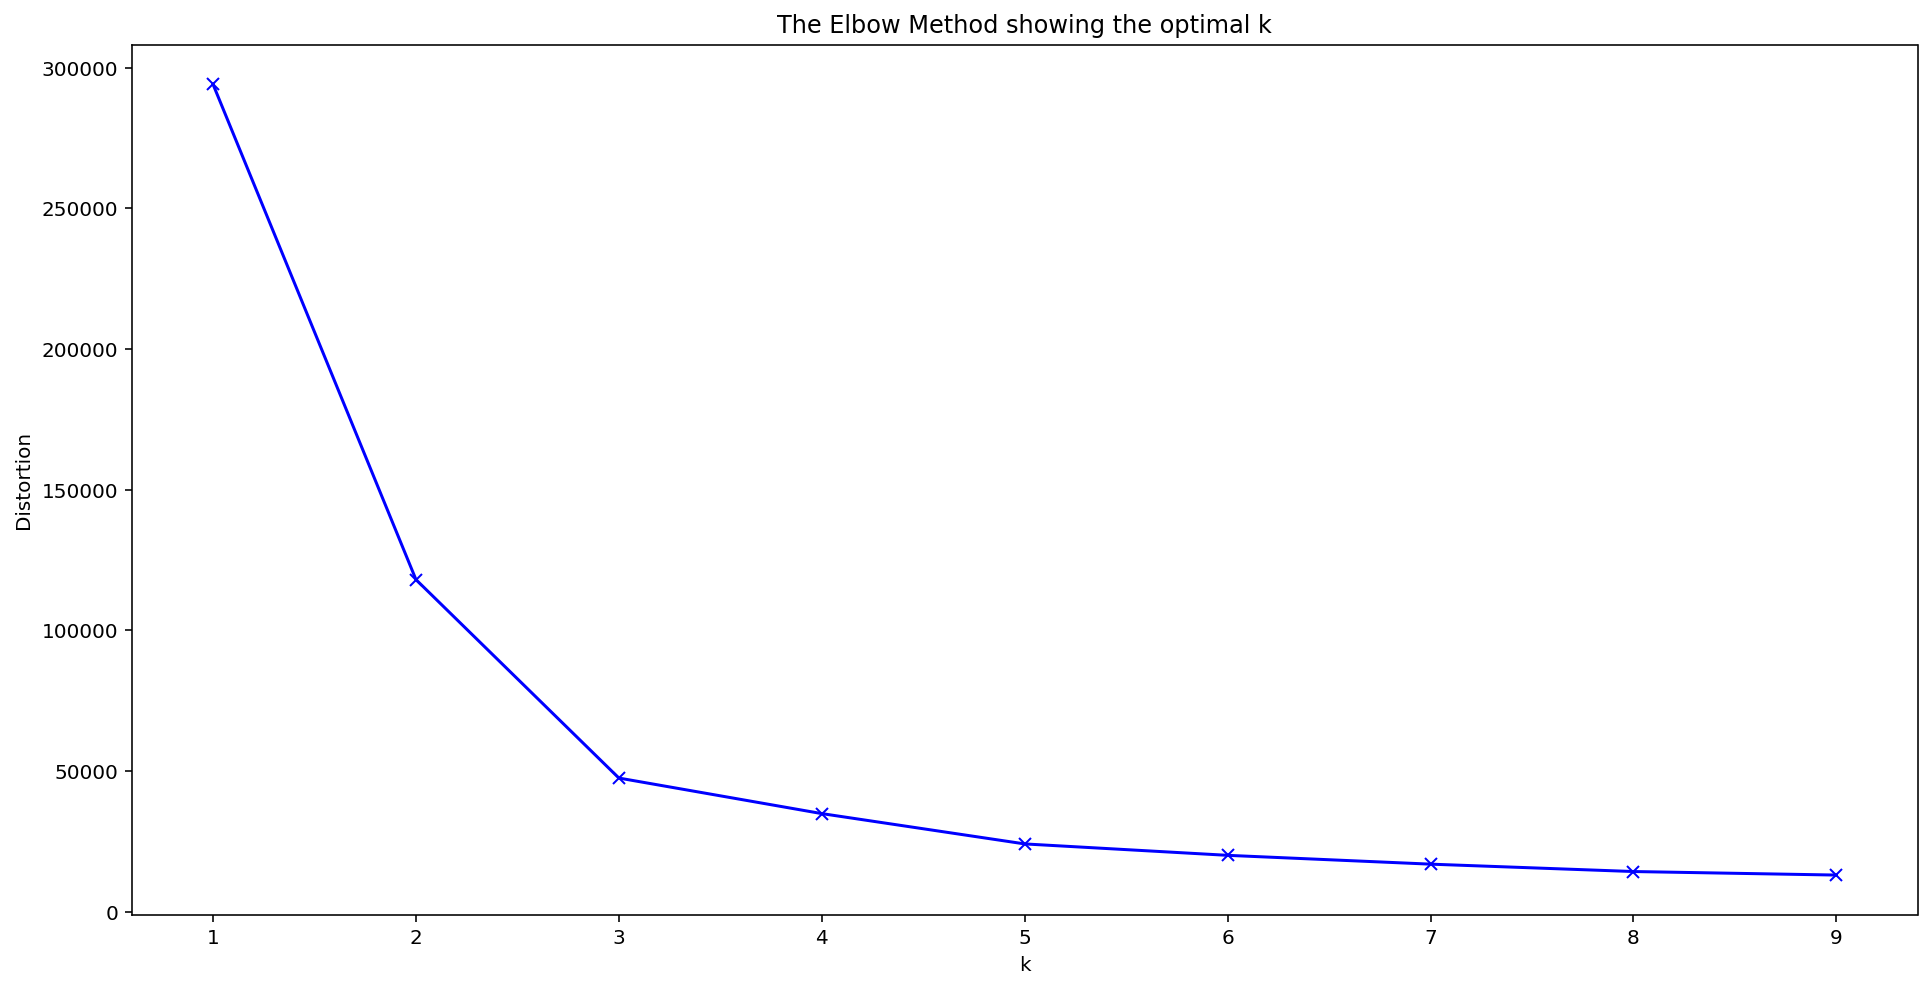

In [46]:
training_features=['danceability','energy','key','loudness','speechiness'
                   ,'acousticness','instrumentalness','liveness','valence','tempo']
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_X[training_features])
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We can observe that the “elbow” is the number 3 which is optimal for this case. Now we can run a K-Means using as n_clusters the number 3.

In [47]:
training_features=['danceability','energy','key','loudness','speechiness'
                   ,'acousticness','instrumentalness','liveness','valence','tempo']
X=MinMaxScaler().fit_transform(df_X[training_features])

kmeans = KMeans(init='random',
               n_clusters=3,
                n_init=10,
                max_iter=300,
                random_state=42).fit(X)

df_X['kmeans']= kmeans.labels_


In [48]:
df_X

,track_id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,kmeans
0,1bxP4M9ICllcg7mel8kH89,0.399,0.395,2,-10.782,0.0593,0.760000,0.000000,0.081500,0.704000,98.174,1
1,1hnk0ZhStnRSLRq4u2fM7H,0.745,0.892,2,-4.574,0.0689,0.185000,0.000006,0.131000,0.768000,114.014,0
2,2itnaJvNPHTUeNrY97fNws,0.728,0.800,0,-3.718,0.1500,0.376000,0.000000,0.194000,0.550000,96.125,0
3,5iqrbO0fhuLMiy9tYGanv6,0.616,0.933,0,-3.762,0.0513,0.025900,0.000000,0.359000,0.806000,129.952,0
4,2On7uB8PN8JJmBNsms8unQ,0.536,0.752,1,-6.556,0.0586,0.524000,0.000000,0.196000,0.939000,76.217,0
...,...,...,...,...,...,...,...,...,...,...,...,...
408,2eAQfT4DYxCBmjaKsO81hp,0.659,0.751,5,-5.239,0.0371,0.117000,0.000070,0.075900,0.702000,93.011,0
409,5mrGKfXvdmfgiiiGE6NcQV,0.783,0.627,2,-6.317,0.1220,0.077400,0.000000,0.239000,0.398000,91.035,0
410,72p1BXnU6YhppFaQtDv6kz,0.895,0.529,7,-8.686,0.2480,0.291000,0.000034,0.091400,0.264000,89.873,1
411,2DazbP5P0QG6j1mPW6Jikh,0.773,0.865,5,-2.944,0.0515,0.267000,0.000000,0.070200,0.957000,109.066,0


With my top 50 songs playlist clustered (cluster 1), We can take a look at the songs that fit in that cluster and make a custom playlist I am garunteed to enjoy. If I wanted to narrow the playlist down some more, I could take the Euclidean distance of each track in cluster 1 compared to my top 50 but I like a big playlist.

In [50]:
df_X.loc[df_X['kmeans'] == 1]

,track_id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,kmeans
0,1bxP4M9ICllcg7mel8kH89,0.399,0.395,2,-10.782,0.0593,0.760000,0.000000,0.081500,0.704000,98.174,1
10,7i6VLLVRwLSXgqWlvjyyOy,0.648,0.479,2,-8.923,0.0312,0.744000,0.001240,0.137000,0.357000,119.439,1
27,5JWihstIukxq7ZVeuH4Am5,0.729,0.556,2,-9.314,0.1000,0.403000,0.000000,0.108000,0.235000,90.009,1
28,06gEzjSwZDuzHoFvD84z5Y,0.359,0.508,9,-6.971,0.0384,0.671000,0.000000,0.094700,0.183000,81.417,1
29,5eqBDCTy4nCZrT8FxwkbW8,0.550,0.731,2,-7.012,0.0767,0.219000,0.000001,0.192000,0.334000,165.980,1
...,...,...,...,...,...,...,...,...,...,...,...,...
399,1hCTxutVVYvggAQcUUUZAT,0.584,0.465,10,-4.880,0.0262,0.678000,0.000000,0.106000,0.299000,95.969,1
401,2uQNcZYa0SEbfW4cj0d9OS,0.454,0.151,9,-13.444,0.0600,0.777000,0.000000,0.079200,0.362000,90.187,1
404,7q2R1SoAcguNj357zGOhhe,0.527,0.538,5,-7.434,0.1040,0.468000,0.000000,0.082500,0.389000,117.319,1
410,72p1BXnU6YhppFaQtDv6kz,0.895,0.529,7,-8.686,0.2480,0.291000,0.000034,0.091400,0.264000,89.873,1


**Create New Playlist**